In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
plt.rcParams.update({
    'figure.figsize': (4.8, 2.7), 'font.size': 15, 'lines.linewidth': 2,
    'xtick.labelsize': 'small', 'ytick.labelsize': 'small',
    'axes.spines.top': False, 'axes.spines.right': False,
    'savefig.dpi': 100,
})

import numpy as np
from pathlib import Path
import os, torch, pickle
from jarvis.utils import tqdm

DATA_DIR = Path('data')
if not os.path.exists(DATA_DIR):
    DATA_DIR = Path('/mnt/c/Projects.Data/foraging/from.Panos_Jun2024')
STORE_DIR = Path('store')

FIG_DIR = Path('figures')
os.makedirs(FIG_DIR, exist_ok=True)

rng = np.random.default_rng()

# Gather precomputed belief results

In [2]:
from hexarena.utils import load_monkey_data, align_monkey_data
from compute_beliefs import prepare_blocks, create_model, create_manager
from identify_policies import fetch_beliefs

subject = 'marco'
data_path = DATA_DIR/f'data_{subject}.mat'
block_ids = prepare_blocks(DATA_DIR, subject)
env, model = create_model(subject)

31 valid blocks found.


## Animation of one block

Block 1 of 20211129


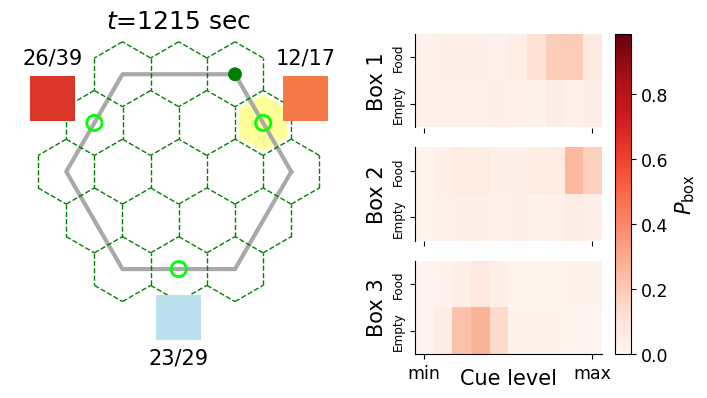

In [3]:
session_id, block_idx = block_ids[0]
print(f'Block {block_idx} of {session_id}')
block_data = load_monkey_data(data_path, session_id, block_idx)
block_data = align_monkey_data(block_data)
env_data = env.convert_experiment_data(block_data)
pos, gaze, colors = env_data['pos'], env_data['gaze'], env_data['colors']
push, success = env_data['push'], env_data['success']
counts = env_data['counts']
rewarded = [None]
for t in range(env_data['num_steps']):
    if push[t]:
        rewarded.append(success[t])
    else:
        rewarded.append(None)
*_, beliefs = fetch_beliefs(DATA_DIR, STORE_DIR, subject, session_id, block_idx)
num_levels = env.boxes[0].num_levels
p_boxes = torch.softmax(
    torch.tensor(beliefs).reshape(-1, 3, 2*num_levels), dim=2,
).reshape(-1, 3, 2, num_levels).numpy()

fig, ani = env.play_episode(
    pos, gaze, rewarded=rewarded, colors=colors, counts=counts, p_boxes=p_boxes, tmin=env_data['num_steps']-240,
)

# HTML(ani.to_jshtml())
ani.save(FIG_DIR/f'belief.dynamics_{subject}_[{session_id}-{block_idx}].mp4', dpi=200)
fig.savefig(FIG_DIR/f'belief.dynamics_{subject}_[{session_id}-{block_idx}].svg')

## Split data into training and testing blocks

In [4]:
idxs = np.random.default_rng(0).choice(len(block_ids), len(block_ids), replace=False)
n_train = int(len(idxs)*0.95)
idxs = {'train': idxs[:n_train], 'test': idxs[n_train:]} # divide all blocks into train and test

ts_wait, observations, actions, knowns, beliefs = {}, {}, {}, {}, {}
for tag in ['train', 'test']:
    ts_wait[tag], observations[tag], actions[tag], knowns[tag], beliefs[tag] = [], [], [], [], []
    for i in tqdm(idxs[tag], desc=tag, unit='block', leave=False):
        session_id, block_idx = block_ids[i]
        _observations, _actions, _knowns, _beliefs = fetch_beliefs(DATA_DIR, STORE_DIR, subject, session_id, block_idx)
        T = len(_actions)
        observations[tag].append(_observations[:T])
        actions[tag].append(_actions[:T])
        knowns[tag].append(_knowns[:T])
        beliefs[tag].append(_beliefs[:T])
        
        block_data = load_monkey_data(DATA_DIR/f'data_{subject}.mat', session_id, block_idx)
        block_data = align_monkey_data(block_data)
        env_data = env.convert_experiment_data(block_data)
        ts_wait[tag].append(env_data['t_wait'][:T])
    ts_wait[tag] = np.concatenate(ts_wait[tag])
    observations[tag] = np.concatenate(observations[tag])
    actions[tag] = np.concatenate(actions[tag])
    knowns[tag] = np.concatenate(knowns[tag])
    beliefs[tag] = np.concatenate(beliefs[tag])

train:   0%|                                                                                                  …

test:   0%|                                                                                                   …

In [5]:
from irc.hmp import HiddenMarkovPolicy

vae_dir = STORE_DIR/'belief_vaes'
os.makedirs(vae_dir, exist_ok=True)
kl_losses = {}
for z_dim in tqdm(range(1, 13)):
    hmp = HiddenMarkovPolicy(model.p_s, z_dim, 2, ebd_b=model.ebd_b)
    vae_path = vae_dir/'belief.vae_[Dz{:02d}].pkl'.format(z_dim)
    try:
        with open(vae_path, 'rb') as f:
            saved = pickle.load(f)
        hmp.belief_vae.load_state_dict(saved['state_dict'])
    except:
        stats = hmp.train_belief_vae(
            torch.tensor(beliefs['train']), z_reg=0.01, pbar_kw={'leave': False},
        )
        with open(STORE_DIR/'belief_vaes/belief.vae_[Dz{:02d}].pkl'.format(z_dim), 'wb') as f:
            pickle.dump({
                'state_dict': hmp.belief_vae.state_dict(),
                'stats': stats,
            }, f)
    with torch.no_grad():
        _, _, recons = hmp.belief_vae(torch.tensor(beliefs['test']), n_scale=0.)
    kl_losses[z_dim] = []
    for i in range(len(recons)):
        d, _ = hmp.belief_vae.p_x.kl_divergence(recons[i], torch.tensor(beliefs['test'][i]))
        kl_losses[z_dim].append(d)
    kl_losses[z_dim] = torch.stack(kl_losses[z_dim])

  0%|                                                                                                         …

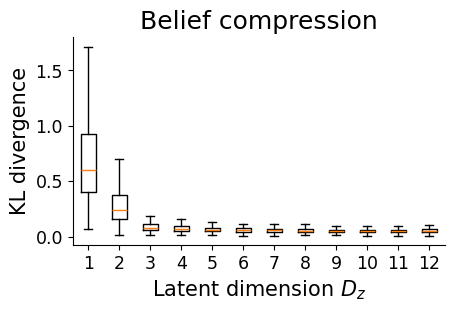

In [6]:
z_dims = np.arange(1, 13)
kls_mean = np.array([kl_losses[z_dim].mean() for z_dim in z_dims])
kls_std = np.array([kl_losses[z_dim].std() for z_dim in z_dims])

fig, ax = plt.subplots()
ax.boxplot(
    [kl_losses[z_dim] for z_dim in z_dims],
    sym='', positions=z_dims,
)
ax.set_xlabel('Latent dimension $D_z$')
ax.set_ylabel('KL divergence')
ax.set_title('Belief compression')
fig.savefig(FIG_DIR/f'belief.compression_{subject}.svg')

## Visualize belief in 3-D latent space

### Coloring by time since last push

In [7]:
hmp = HiddenMarkovPolicy(model.p_s, 3, 2, ebd_b=model.ebd_b)
with open(vae_dir/'belief.vae_[Dz{:02d}].pkl'.format(3), 'rb') as f:
    saved = pickle.load(f)
hmp.belief_vae.load_state_dict(saved['state_dict'])
zs = hmp.compress_beliefs(torch.tensor(beliefs['train']))

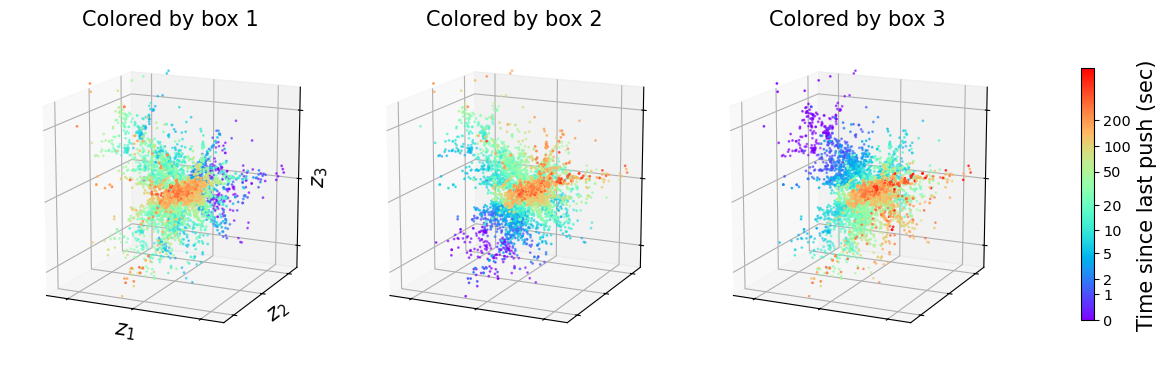

In [8]:
fig = plt.figure(figsize=(14, 4))
idxs = rng.choice(len(zs), 5000)
cmax = np.log(1+ts_wait['train'][idxs].max())
margin, gap = 0.05, 0.02
width = (1-2*margin-2*gap)/3
axes, artists = [], []
for i in range(3):
    ax = fig.add_axes([margin+(width+gap)*i, 0.05, width, 0.9], projection='3d', elev=15)
    artists.append(ax.scatter(
        zs[idxs, 0], zs[idxs, 1], zs[idxs, 2], s=1,
        c=np.log(1+ts_wait['train'][idxs, i]), cmap='rainbow', vmin=0, vmax=cmax,
    ))
    ax_lim = [-4, 4]
    ax.set_xlim(ax_lim), ax.set_ylim(ax_lim), ax.set_zlim(ax_lim)
    ax.set_aspect('equal')
    ax_ticks = [-3, 0, 3]
    ax.set_xticks(ax_ticks), ax.set_yticks(ax_ticks), ax.set_zticks(ax_ticks)
    ax.set_xticklabels([]), ax.set_yticklabels([]), ax.set_zticklabels([])
    if i==0:
        ax.set_xlabel('$z_1$', labelpad=-10), ax.set_ylabel('$z_2$', labelpad=-10), ax.set_zlabel('$z_3$', labelpad=-10)
    ax.set_title(f'Colored by box {i+1}', fontsize='medium')
    axes.append(ax)
cbar = plt.colorbar(artists[0], ax=axes, shrink=0.7, label='Time since last push (sec)')
ticks = np.array([0, 1, 2, 5, 10, 20, 50, 100, 200])
cbar.ax.set_yticks(np.log(1+ticks/env.dt))
cbar.ax.set_yticklabels(['{:d}'.format(x) for x in ticks], fontsize='x-small')

def update(t, total=36):
    az = (t/total)*360-60
    for ax in axes:
        ax.view_init(azim=az)
    return artists

total = 72
ani = FuncAnimation(
    fig, update, fargs=(total,), frames=range(total), blit=True,
)

# HTML(ani.to_jshtml())
ani.save(FIG_DIR/f'colored.belief.space_{subject}.mp4', dpi=200)
fig.savefig(FIG_DIR/f'colored.belief.space_{subject}.svg')

### Trace in belief space

Block 1 of 20211129


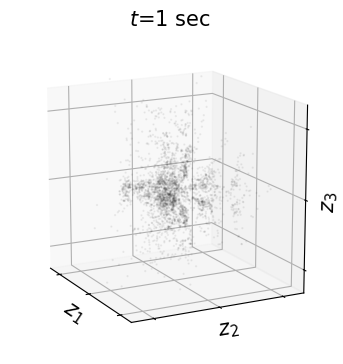

In [9]:
fig = plt.figure(figsize=(4, 4))
ax = fig.add_axes([0.05, 0.05, 0.9, 0.8], projection='3d', elev=15)
idxs = rng.choice(len(zs), 3000)
ax.scatter(zs[idxs, 0], zs[idxs, 1], zs[idxs, 2], s=0.5, c='black', alpha=0.05)
ax.set_xlim(ax_lim), ax.set_ylim(ax_lim), ax.set_zlim(ax_lim)
ax.set_aspect('equal')
ax.set_xticks(ax_ticks), ax.set_yticks(ax_ticks), ax.set_zticks(ax_ticks)
ax.set_xticklabels([]), ax.set_yticklabels([]), ax.set_zticklabels([])
ax.set_xlabel('$z_1$'), ax.set_ylabel('$z_2$'), ax.set_zlabel('$z_3$')
ax.set_xlabel('$z_1$', labelpad=-10), ax.set_ylabel('$z_2$', labelpad=-10), ax.set_zlabel('$z_3$', labelpad=-10)

session_id, block_idx = block_ids[0]
print(f'Block {block_idx} of {session_id}')
*_, beliefs_block = fetch_beliefs(DATA_DIR, STORE_DIR, subject, session_id, block_idx)
zs_block = hmp.compress_beliefs(torch.tensor(beliefs_block))
trace_len = 20
h = ax.scatter(zs_block[:trace_len, 0], zs_block[:trace_len, 1], zs_block[:trace_len, 2], s=20, c=np.arange(trace_len), cmap='Greens')
h_title = ax.set_title('', fontsize='medium')

def update(t):
    az = 2.5*t-30
    ax.view_init(azim=az)
    h.set_offsets(zs_block[t-trace_len:t, :2])
    h.set_3d_properties(zs_block[t-trace_len:t, 2], 'z')
    h_title.set_text(r'$t$='+'{}'.format(
        '{:d} sec'.format(int(np.floor(t*env.dt)))
    ))
    return h, h_title

ani = FuncAnimation(
    fig, update, frames=range(len(beliefs)-240, len(beliefs)), blit=True,
)
# HTML(ani.to_jshtml())
ani.save(FIG_DIR/f'belief.trace_{subject}_[{session_id}-{block_idx}].mp4', dpi=200)
fig.savefig(FIG_DIR/f'belief.trace_{subject}_[{session_id}-{block_idx}].svg')

# Policy identification using hidden Markov model

# Identify distinct policies

In [3]:
from identify_policies import create_manager

manager = create_manager(DATA_DIR, STORE_DIR, subject, block_ids)
manager.load_tar('store/policies.tar.gz')

Collect data:   0%|                                                                                           …

Extracting files from tar:   0%|                                                                              …

Copying 'configs':   0%|                                                                                      …

Copying 'stats':   0%|                                                                                        …

Copying 'ckpts':   0%|                                                                                        …

In [32]:
cond = {
    'num_policies': 3, 'num_macros': 10,
    'reg_coefs.alpha_A': 0.,
}
keys = [key for key, _ in manager.completed(min_epoch=10, cond=cond)]

In [33]:
len(keys)

2

In [34]:
[manager.stats[key] for key in keys]

[{'complete': False, 'epoch': 50, 't_modified': 1727551983.1581566},
 {'complete': False, 'epoch': 50, 't_modified': 1727526937.1075957}]

In [35]:
from jarvis.utils import array2tensor
ckpt = array2tensor(manager.ckpts[keys[0]])
ckpt.keys()

dict_keys(['knowns', 'beliefs', 'actions', 'pis', 'As', 'lls', 'gammas', 'log_Zs', 'log_gammas', 'log_xis'])

In [42]:
ckpt['knowns'][0].shape

torch.Size([1215, 2])

In [37]:
torch.stack(ckpt['As'])[-1]

tensor([[0.0081, 0.5754, 0.4165],
        [0.0544, 0.8195, 0.1262],
        [0.1267, 0.0729, 0.8005]], dtype=torch.float64)

In [41]:
ckpt['gammas'][0][0]

torch.Size([1215, 3])

In [10]:
from identify_policies import init_hmp

z_dim, num_macros = 3, 10
num_policies = 2
hmp = init_hmp(model, z_dim, num_macros, num_policies, STORE_DIR)

save_path = STORE_DIR/'policies_{}_[Dz{:02d}][Np{:d}][Na{:d}].pkl'.format(
    subject, z_dim, num_policies, num_macros,
)
with open(save_path, 'rb') as f:
    saved = pickle.load(f)

for policy, state in zip(hmp.policies, saved['policies']):
    policy.load_state_dict(state)

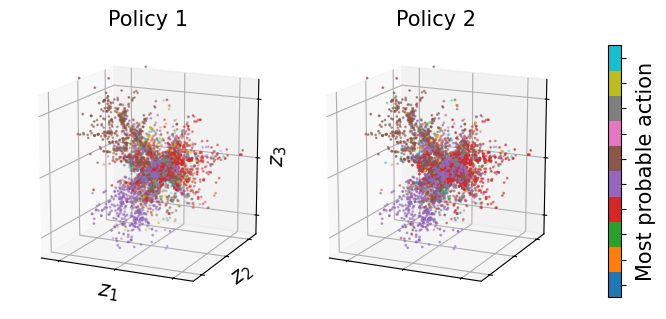

In [14]:
import matplotlib as mpl

zs = hmp.compress_beliefs(torch.tensor(beliefs['train']))
idxs = rng.choice(len(zs), 5000)

fig = plt.figure(figsize=(8, 4))
palette = plt.get_cmap('tab10').colors
assert np.array(palette).shape==(num_macros, 3)
margin, gap = 0.05, 0.02
width = (1-2*margin-2*gap)/num_policies
axes, artists = [], []
for i in range(num_policies):
    with torch.no_grad():
        logits = hmp.policies[i](hmp.policy_inputs(torch.tensor(knowns['train']), torch.tensor(beliefs['train'])))
    _, a_idxs = logits.max(dim=1)
    probs = torch.softmax(logits, dim=1)
    cs = []
    for a_idx, prob in zip(a_idxs, probs):
        cs.append((*palette[a_idx], prob[a_idx].item()))
    cs = np.array(cs)
    
    ax = fig.add_axes([margin+(width+gap)*i, 0.05, width, 0.9], projection='3d', elev=15)
    artists.append(ax.scatter(
        zs[idxs, 0], zs[idxs, 1], zs[idxs, 2], s=1, c=cs[idxs],
    ))
    ax_lim = [-4, 4]
    ax.set_xlim(ax_lim), ax.set_ylim(ax_lim), ax.set_zlim(ax_lim)
    ax.set_aspect('equal')
    ax_ticks = [-3, 0, 3]
    ax.set_xticks(ax_ticks), ax.set_yticks(ax_ticks), ax.set_zticks(ax_ticks)
    ax.set_xticklabels([]), ax.set_yticklabels([]), ax.set_zticklabels([])
    if i==0:
        ax.set_xlabel('$z_1$', labelpad=-10), ax.set_ylabel('$z_2$', labelpad=-10), ax.set_zlabel('$z_3$', labelpad=-10)
    ax.set_title(f'Policy {i+1}', fontsize='medium')
    axes.append(ax)
cbar = plt.colorbar(
    mpl.cm.ScalarMappable(cmap='tab10'), ax=axes, shrink=0.7,
    label='Most probable action',
)
cbar.ax.set_yticks((np.arange(num_macros)+0.5)/num_macros)
cbar.ax.set_yticklabels([])

def update(t, total=36):
    az = (t/total)*360-60
    for ax in axes:
        ax.view_init(azim=az)
    return artists

total = 72
ani = FuncAnimation(
    fig, update, fargs=(total,), frames=range(total), blit=True,
)

# HTML(ani.to_jshtml())
ani.save(FIG_DIR/f'policies_{subject}_[Np{num_policies}].mp4', dpi=200)
fig.savefig(FIG_DIR/f'policies_{subject}_[Np{num_policies}].svg')

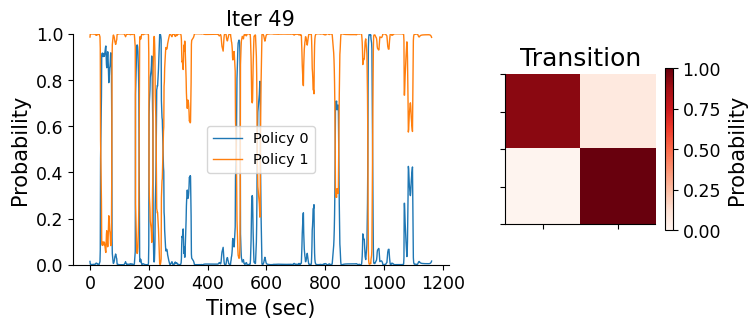

In [21]:
gammas = saved['gammas'][2]
As = saved['As']

fig, axes = plt.subplots(1, 2, figsize=(8, 3), gridspec_kw={'width_ratios': [2, 1]})
ax = axes[0]
h_gammas = ax.plot(gammas[0], linewidth=1)
h_title = ax.set_title('', fontsize='medium')
ax.set_xlabel('Time (sec)')
ax.set_ylabel('Probability')
ax.set_ylim([0, 1])
ax.legend(h_gammas, [f'Policy {i}' for i in range(num_policies)], fontsize='x-small')
ax = axes[1]
h_A = ax.imshow(As[0], vmin=0, vmax=1, cmap='Reds')
ax.set_xticklabels([]), ax.set_yticklabels([])
ax.set_title('Transition')
plt.colorbar(
    h_A, ax=ax, shrink=0.7, label='Probability',
)

def update(t):
    for i in range(num_policies):
        h_gammas[i].set_ydata(gammas[t, :, i])
    h_A.set_data(As[t])
    h_title.set_text(f'Iter {t}')
    return *h_gammas, h_A, h_title

ani = FuncAnimation(
    fig, update, frames=range(len(gammas)), blit=True,
)

# HTML(ani.to_jshtml())
ani.save(FIG_DIR/f'EM.iteration_{subject}_[Np{num_policies}].mp4', dpi=200)
fig.savefig(FIG_DIR/f'EM.iteration_{subject}_[Np{num_policies}].svg')